# Area of prediction -test-

This notebook develops the method for a morphological analysis of urban blocks that define the area of prediction for the urban land use prediction model.

## Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mp
from shapely import wkt

import seaborn as sns
import matplotlib.pyplot as plt 

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

/home/edgaregurrola/.cache/pypoetry/virtualenvs/aup-qDsIK5d5-py3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data download/read and preprocessing

### Area of analysis

In [2]:
aoa_gdf = gpd.read_file("../../data/processed/prediccion_uso_suelo/Distrito_Zona5.geojson")
print(aoa_gdf.shape)
aoa_gdf.head(2)

(1, 4)


,id,area,perimeter,geometry
0,0,3.456908e+07,22034.335455,"POLYGON ((662437.93 2284457.02, 662421.516 228..."


<Axes: >

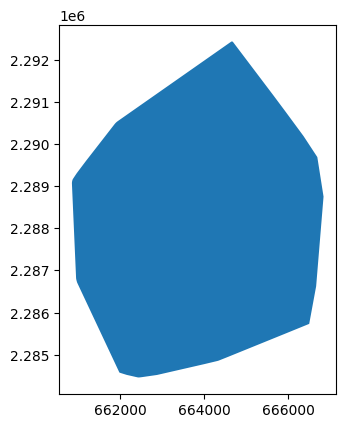

In [3]:
aoa_gdf.plot()

### Buildings footprints

In [4]:
bld_gdf = pd.read_csv('../../data/processed/prediccion_uso_suelo/843_buildings.csv')
bld_gdf['geometry'] = bld_gdf['geometry'].apply(wkt.loads)
bld_gdf = gpd.GeoDataFrame(bld_gdf, crs='epsg:4326')
bld_gdf = bld_gdf.to_crs("EPSG:32613")
print(bld_gdf.shape)
bld_gdf.head(2)

(17536895, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
0,18.364032,-100.670645,60.4298,0.8018,"POLYGON ((957724.317 2035917.636, 957716.543 2...",75CX987H+JP97
1,20.446907,-103.526685,10.5973,0.7524,"POLYGON ((653691.558 2261626.324, 653691.012 2...",75GRCFWF+Q886


Filter data

In [5]:
bld_clip = gpd.clip(bld_gdf, aoa_gdf)
bld_gdf = bld_gdf.loc[bld_gdf.full_plus_code.isin(list(bld_clip.full_plus_code.unique()))].copy()
print(bld_gdf.shape)
bld_gdf.head(2)

(91599, 6)


,latitude,longitude,area_in_meters,confidence,geometry,full_plus_code
62,20.689225,-103.450063,15.1462,0.7894,"POLYGON ((661430.451 2288523.131, 661431.347 2...",75GRMGQX+MXV5
254,20.693999,-103.408600,105.0053,0.7422,"POLYGON ((665737.418 2289088.563, 665750.944 2...",75GRMHVR+HHRX


Dissolve overlaping buildings

In [6]:
# dismiss dissolve to avoid merging continous buildings
# bld_gdf = bld_gdf.dissolve().explode()
# print(bld_gdf.shape)
# bld_gdf.head(2)

<Axes: >

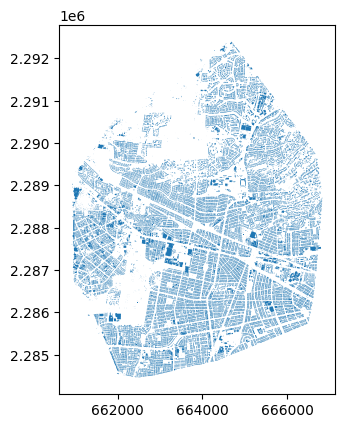

In [7]:
bld_gdf.plot()

### Land use data

In [8]:
use_gdf = gpd.read_file('../../data/processed/prediccion_uso_suelo/USOS_ZONA_5.shp')
print(use_gdf.shape)
use_gdf.head(2)

(44927, 7)


,gid,id,distrito,shape_leng,shape_area,UNUSO,geometry
0,383802,225938.0,5.0,87.833373,372.671854,Baldio,"POLYGON ((663603.887 2289224.482, 663592.822 2..."
1,383514,465151.0,5.0,156.734778,1505.830715,None,"POLYGON ((661583.201 2289149.452, 661563.62 22..."


In [9]:
use_gdf.UNUSO.unique()

array(['Baldio', None, 'Comercio', 'Habitacional', 'Espacios_verdes',
       'Equipamiento_institucional', 'Servicios', 'Industria',
       'Infraestructura', 'Mixto', 'Servicios_a_la_industria',
       'Turistico_hotelero'], dtype=object)

### Block data

In [10]:
poly_wkt = aoa_gdf.to_crs("EPSG:4326").dissolve().geometry.to_wkt()[0]

In [11]:
schema = 'marco'
table = 'mza_2020'
query = f"SELECT * FROM {schema}.{table} WHERE ST_Intersects(geometry, 'SRID=4326;{poly_wkt}')"
block_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(block_gdf.shape)
block_gdf.head(2)

(1826, 9)


,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,AMBITO,TIPOMZA,geometry
0,1403900011043028,14,039,0001,1043,028,Urbana,Típica,"POLYGON ((-103.4017 20.6807, -103.40161 20.680..."
1,1403900011043027,14,039,0001,1043,027,Urbana,Típica,"POLYGON ((-103.39983 20.68393, -103.39976 20.6..."


## Create prediction area

### Filter buildings by blocks

In [12]:
block_gdf = block_gdf.to_crs("EPSG:32613")
block_gdf = block_gdf[['CVEGEO','geometry']].copy()

In [13]:
bld_block = gpd.overlay(bld_gdf, block_gdf, how='intersection')
print(bld_block.shape)
bld_block.head(2)

(90921, 7)


,latitude,longitude,area_in_meters,confidence,full_plus_code,CVEGEO,geometry
0,20.689225,-103.450063,15.1462,0.7894,75GRMGQX+MXV5,1412000011206018,"POLYGON ((661426.815 2288523.955, 661427.711 2..."
1,20.693999,-103.408600,105.0053,0.7422,75GRMHVR+HHRX,141200001116A008,"POLYGON ((665736.12 2289090.928, 665738.325 22..."


### Building morphology

Morphology analysis for each building within it's respective urban block.

In [14]:
def fix_overlapping_bld(gdf):
    # intersect buildings with themsleves
    bld_int = gdf[['full_plus_code','geometry']].overlay(gdf[['full_plus_code','geometry']],
                                                         how='intersection', keep_geom_type=True)
    # count the number of intersections per building
    bld_counter = bld_int.groupby('full_plus_code_1').count()
    # filter building with at least two overlaps
    bld_counter = bld_counter.loc[bld_counter.geometry>=2].reset_index()

    processed_int = [] # save processed buildings to avoid duplicates

    for code_1 in bld_counter.full_plus_code_1:
        # identify buildings to be processed
        bld_int_list = [code_1]
        bld_int_list.extend(list(bld_int.loc[bld_int.full_plus_code_1==code_1].full_plus_code_2))
        bld_int_list = list(set(bld_int_list)) # remove duplicate values

        # recalculate area
        gdf['area_m2'] = gdf.area

        # filter complete buildings from original GeoDataFrame
        bld_tmp = gdf.loc[gdf.full_plus_code.isin(bld_int_list)].copy()

        # sort values so largest area is first
        bld_tmp = bld_tmp.sort_values('area_m2', ascending=False)
        bld_tmp = bld_tmp.reset_index()
    
        # always select the bigger area
        bld_diff = bld_tmp.loc[bld_tmp.index==0]
        code_int_1 = bld_tmp.loc[0,'full_plus_code']
    
        # iterate over smaller overlapping areas
        for i,_ in bld_tmp.loc[bld_tmp.index!=0].iterrows():
            code_int_2 = bld_tmp.loc[0,'full_plus_code']

            # check if buildings where previously processed
            if code_int_1+'-'+code_int_2 in processed_int:
                continue
    
            # if buildings haven't been processed analyze the case
            processed_int.append(code_int_1+'-'+code_int_2)
            processed_int.append(code_int_2+'-'+code_int_1)
    
            # calculate geometric difference
            geom_diff = bld_tmp.loc[bld_tmp.index==i].difference(bld_diff, align=False)
            gdf.loc[gdf.full_plus_code==code_int_2, 'geometry'] = geom_diff
            gdf['area_m2'] = gdf.area

    return gdf

In [15]:
tess_gdf = gpd.GeoDataFrame()

for cvegeo in bld_block.CVEGEO.unique():
    bld_filter = bld_block.loc[bld_block.CVEGEO==cvegeo].copy()
    block_filter = block_gdf.loc[block_gdf.CVEGEO==cvegeo].copy()

    # skip if there aren't any buildings for that specific block
    if bld_filter.empty:
        continue
    try:  
        tess_tmp = mp.morphological_tessellation(bld_filter, clip=block_filter)
    except:
        # bld_filter = fix_overlapping_bld(bld_filter)
        # bld_filter = bld_filter.dissolve().explode()
        # tess_tmp = mp.morphological_tessellation(bld_filter, clip=block_filter)
        continue
    
    # assign block's geographic code
    tess_tmp['CVEGEO'] = cvegeo

    # transfer code and building area data
    tess_tmp = tess_tmp.reset_index().rename(columns={'index':'fid'})
    bld_filter = bld_filter[['full_plus_code','area_in_meters']].reset_index().rename(columns={'index':'fid'}).copy()
    tess_tmp = tess_tmp.merge(bld_filter, on=['fid'])
    tess_tmp = tess_tmp.drop(columns=['fid'])

    # add data to complete GeoDataFrame
    tess_gdf = pd.concat([tess_gdf, tess_tmp])

print(tess_gdf.shape)
tess_gdf.head(2)

(89763, 4)


,geometry,CVEGEO,full_plus_code,area_in_meters
0,"POLYGON ((661426.68 2288511.113, 661426.549 22...",1412000011206018,75GRMGQX+MXV5,15.1462
1,"POLYGON ((661486.546 2288636.13, 661485.999 22...",1412000011206018,75GRMHR2+458V,173.7348


<Axes: >

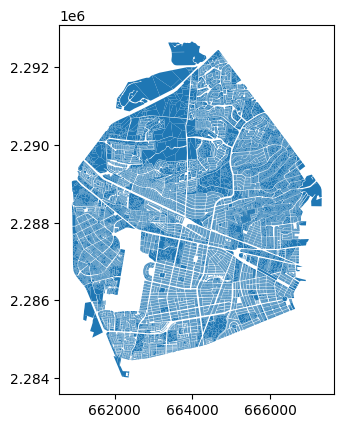

In [16]:
tess_gdf.plot()

## Land use to area of prediction

In [17]:
tess_gdf = tess_gdf.rename(columns={'area_in_meters':'bld_area_m2'})

In [18]:
# fix row numbers
tess_gdf = tess_gdf.reset_index(drop=True).reset_index().rename(columns={'index':'fid'})
tess_gdf.head(1)

,fid,geometry,CVEGEO,full_plus_code,bld_area_m2
0,0,"POLYGON ((661426.68 2288511.113, 661426.549 22...",1412000011206018,75GRMGQX+MXV5,15.1462


Spatial intersection

In [19]:
tess_uso = tess_gdf.overlay(use_gdf[['UNUSO','geometry']], how='intersection')
print(tess_uso.shape)
tess_uso.head(2)

(227113, 6)


,fid,CVEGEO,full_plus_code,bld_area_m2,UNUSO,geometry
0,0,1412000011206018,75GRMGQX+MXV5,15.1462,None,"POLYGON ((661426.549 2288511.045, 661426.148 2..."
1,0,1412000011206018,75GRMGQX+MXV5,15.1462,None,"POLYGON ((661420.842 2288516.067, 661422.086 2..."


Identify missing values

In [20]:
tess_uso.loc[tess_uso.UNUSO.isna()]

,fid,CVEGEO,full_plus_code,bld_area_m2,UNUSO,geometry
0,0,1412000011206018,75GRMGQX+MXV5,15.1462,None,"POLYGON ((661426.549 2288511.045, 661426.148 2..."
1,0,1412000011206018,75GRMGQX+MXV5,15.1462,None,"POLYGON ((661420.842 2288516.067, 661422.086 2..."
3,2,1412000011206018,75GRMGRX+GQP3,81.7922,None,"POLYGON ((661362.934 2288734.594, 661362.547 2..."
4,3,1412000011206018,75GRMGQX+CP2J,31.6437,None,"POLYGON ((661354.699 2288442.864, 661354.701 2..."
5,4,1412000011206018,75GRMGQX+955Q,12.7223,None,"POLYGON ((661220.817 2288427.439, 661220.724 2..."
...,...,...,...,...,...,...
225136,88938,1412000012365028,75GRMHHW+QF4G,115.1518,None,"POLYGON ((666263.654 2287478.68, 666263.021 22..."
225166,88947,1412000012365028,75GRMHHW+PF86,185.8626,None,"POLYGON ((666254.384 2287476.852, 666254.685 2..."
225958,89269,1412000013202005,75GRMH69+F23G,163.1095,None,"POLYGON ((663298.806 2285439.2, 663300.2 22854..."
226678,89576,1412000013217050,75GRMH39+H583,197.9008,None,"POLYGON ((663334.571 2284630.891, 663335.088 2..."


Remove entire blocks with some missing value

Number of missing blocks: 178 out of: 1826


<Axes: >

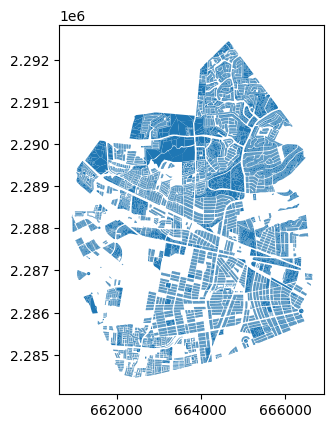

In [21]:
missing_list = list(tess_uso.loc[tess_uso.UNUSO.isna()].CVEGEO.unique())
print('Number of missing blocks:',len(missing_list),'out of:',len(block_gdf))
tess_uso = tess_uso.loc[~tess_uso.CVEGEO.isin(missing_list)].copy()
tess_uso.plot()

Filter majority use by area of prediction

In [22]:
tess_uso['area_m2'] = tess_uso.area

In [23]:
tess_uso = tess_uso.groupby(['fid','UNUSO']).sum(numeric_only=True).reset_index()
tess_uso = tess_uso.drop(columns=['bld_area_m2'])
tess_uso = tess_uso.sort_values(by=['fid','area_m2'],ascending=False).groupby('fid').first()
print(tess_uso.shape)
tess_uso.head(4)

(64788, 2)


,UNUSO,area_m2
fid,,
359,Habitacional,808.230624
360,Habitacional,439.648229
361,Habitacional,319.166968
362,Espacios_verdes,370.156524


Add geometry

In [24]:
tess_uso = tess_uso.merge(tess_gdf[['fid','full_plus_code','CVEGEO','bld_area_m2','geometry']],
                         on='fid')
# convert to GeoDataFrame
tess_uso = gpd.GeoDataFrame(tess_uso)
tess_uso = tess_uso.set_crs("EPSG:32613")

print(tess_uso.shape)
tess_uso.head(2)

(64788, 7)


,fid,UNUSO,area_m2,full_plus_code,CVEGEO,bld_area_m2,geometry
0,359,Habitacional,808.230624,75GRMHVR+HHRX,141200001116A008,105.0053,"POLYGON ((665738.958 2289088.14, 665738.935 22..."
1,360,Habitacional,439.648229,75GRMHXX+W5F8,141200001116A008,80.8571,"POLYGON ((666412.897 2289726.843, 666412.614 2..."


<Axes: >

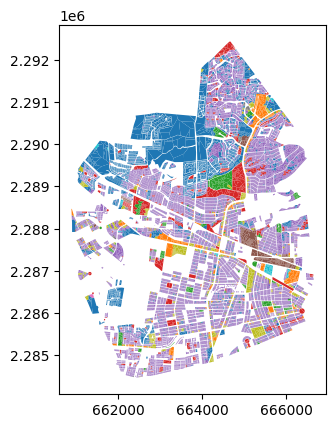

In [25]:
tess_uso.plot('UNUSO')

Save data

In [26]:
tess_uso.to_file('../../data/processed/prediccion_uso_suelo/tess_uso_test.geojson')